## IMPORTOWANIE BIBLIOTEK I WCZYTANIE DANYCH

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

from scipy import stats
from scipy.stats import spearmanr, chi2_contingency

from mplsoccer import VerticalPitch

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss, 
    precision_recall_curve, auc, roc_curve, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
path = r"D:\football_project\all_shots_combined_2015_2016.csv"
df = pd.read_csv(path)
print(df.shape)
print(df.head())

(45719, 121)
   Unnamed: 0  50_50  ball_receipt_outcome  ball_recovery_recovery_failure  \
0        3487    NaN                   NaN                             NaN   
1        3488    NaN                   NaN                             NaN   
2        3489    NaN                   NaN                             NaN   
3        3490    NaN                   NaN                             NaN   
4        3491    NaN                   NaN                             NaN   

   carry_end_location  clearance_aerial_won  clearance_body_part  \
0                 NaN                   NaN                  NaN   
1                 NaN                   NaN                  NaN   
2                 NaN                   NaN                  NaN   
3                 NaN                   NaN                  NaN   
4                 NaN                   NaN                  NaN   

   clearance_head  clearance_left_foot  clearance_other  ...  \
0             NaN                  NaN       

Wczytany zbiór danych jest mocno rozbudowany. Zawiera 45 719 obserwacji oraz 121 zmiennych. Jednak już na pierwszy rzut oka można zauważyć, że nie wszystkie zmienne są powiązane ze strzałami. W związku z tym już teraz mogę usunąć zmienne, które dla wszystkich obserwacji przyjmują wartość NaN.

In [3]:
df = df.dropna(axis=1, how='all')
print(df.shape)
print(df.columns)

(45719, 41)
Index(['Unnamed: 0', 'duration', 'id', 'index', 'location', 'match_id',
       'minute', 'off_camera', 'out', 'period', 'play_pattern', 'player',
       'player_id', 'position', 'possession', 'possession_team',
       'possession_team_id', 'related_events', 'second', 'shot_aerial_won',
       'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_freeze_frame', 'shot_key_pass_id', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type', 'team', 'team_id',
       'timestamp', 'type', 'under_pressure', 'shot_one_on_one',
       'shot_deflected', 'shot_open_goal', 'shot_redirect',
       'shot_saved_off_target', 'shot_follows_dribble', 'shot_saved_to_post'],
      dtype='object')


W wyniku tej operacji rozmiar zbioru zmniejszył się do 41 kolumn. Po przejrzeniu pozostałych zmiennych udało mi się wybrać te potencjalnie istotne dla przyszłego modelu.

## WSTĘPNY ZBIÓR DANYCH BEZ OBRÓBKI ZMIENNYCH

In [4]:
feature = [
    'shot_outcome', # zmienna objaśniana
    'under_pressure', 'location', 
    'shot_technique', 'shot_body_part',
    'shot_type', 'shot_first_time', 'shot_open_goal',
    'shot_one_on_one', 'shot_follows_dribble', 'shot_freeze_frame',
    'player_id', # do transformacji shot_body_part
    'shot_statsbomb_xg', #jedynie do końcowego porównania trendów między modelami
]

Do dalszej obróbki wybrałem następujące zmienne:
- **shot_outcome** - przyszła zmienna objaśniana opisująca rezultat oddanego strzału,
- **under_pressure** - zmienna binarna; czy strzał był oddawany pod presją przeciwnika,
- **location** - zmienna informująca o lokalizacji, z której oddano strzał; koordynaty x (0-120) oraz y (0-80),
- **shot_technique** - zmienna kategorialna; technika oddania strzału,
- **shot_body_part** - zmienna kategorialna; część ciała którą oddano strzał,
- **shot_type** - zmienna kategorialna; w jakiej sytuacji oddano strzał: "z gry", z rzutu wolnego, z rzutu karnego, itp.
- **shot_first_time** - zmienna binarna; czy strzał był odddany z pierwszej piłki (bez przyjęcia),
- **shot_open_goal** - zmienna binarna; czy strzał był odddany "do pustej bramki",
- **shot_one_to_one** - zmienna binarna; czy strzał był odddany w wyniku sytuacji "jeden na jednego",
- **shot_follows_dribble** - zmienna binarna; czy strzał był odddany po dryblingu,
- **shot_freeze_frame** - zmienna zawierająca lokalizacje innych zawodników w momencie oddania strzału;
- **player_id** - zmienna pomocnicza; numer identyfikacyjny piłkarza,
- **shot_statsbomb_xg** - zmienna pomocnicza użyta w celu ewaluacji modelu; wartość expected goals wyliczona przez algorytmy StatsBomb

In [5]:
df_shots = df[feature]
df_shots.head()

,shot_outcome,under_pressure,location,shot_technique,shot_body_part,shot_type,shot_first_time,shot_open_goal,shot_one_on_one,shot_follows_dribble,shot_freeze_frame,player_id,shot_statsbomb_xg
0,Goal,True,"[112.0, 35.7]",Normal,Head,Open Play,NaN,NaN,NaN,NaN,"[{'location': [111.5, 8.3], 'player': {'id': 8...",7017.0,0.074454
1,Blocked,NaN,"[96.1, 19.5]",Normal,Left Foot,Open Play,NaN,NaN,NaN,NaN,"[{'location': [99.1, 42.5], 'player': {'id': 5...",31231.0,0.008508
2,Saved,True,"[110.3, 41.2]",Normal,Head,Open Play,NaN,NaN,NaN,NaN,"[{'location': [105.5, 29.6], 'player': {'id': ...",8871.0,0.085069
3,Goal,NaN,"[108.1, 40.1]",Normal,Right Foot,Penalty,NaN,NaN,NaN,NaN,NaN,386607.0,0.783500
4,Off T,NaN,"[110.5, 23.4]",Half Volley,Left Foot,Open Play,True,NaN,NaN,NaN,"[{'location': [108.1, 30.7], 'player': {'id': ...",7017.0,0.011791


## TRANSFORMACJA ZMIENNEJ OBJAŚNIANEJ W ZMIENNĄ BINARNĄ

Pierwszym krokiem po zdefiniowaniu zbioru danych było utworzenie zmiennej docelowej poprzez transformację zmiennej *shot_outcome* w zmienną binarną.

In [6]:
print(df_shots['shot_outcome'].value_counts(normalize=True)*100)

df_shots['shot_outcome'] = np.where(df_shots['shot_outcome']=='Goal',
                                    1, 0)
print(50*'-')
print(df_shots['shot_outcome'].value_counts(normalize=True)*100)

shot_outcome
Off T               33.003784
Blocked             24.698703
Saved               23.500077
Goal                10.293314
Wayward              5.914390
Post                 1.902929
Saved Off Target     0.352151
Saved to Post        0.334653
Name: proportion, dtype: float64
--------------------------------------------------
shot_outcome
0    89.706686
1    10.293314
Name: proportion, dtype: float64


C:\Users\Bartek\AppData\Local\Temp\ipykernel_16308\594979794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shots['shot_outcome'] = np.where(df_shots['shot_outcome']=='Goal',


Pierwotnie zmienna zawierała wiele kategorii. Dla mnie natomiast istotne było jedynie rozróżnienie: gol vs nie gol. W związku z tym do obserwacji z etykietą "Goal" przypisałem 1 a do pozostałych 0. Jak się okazało jedynie około 10% wszystkich strzałów zakończyło się zdobyciem bramki. Jest to zgodne z powszechnie obserwowanym zjawiskiem w piłce nożnej, gdzie średnio co 10 akcja ofensywna kończy się strzałem, a co 10 strzał kończy się golem. W rezultacie ledwie 1% akcji ofensywnych jest zwieńczonych strzeleniem bramki. 

Dla modelu predykcyjnego tak silne niezrównoważenie klas nie jest korzystne (stronniczość modelu w kierunku przeważającej klasy). W związku z tym przed trenowaniem modelu konieczne będzie dokonanie resamplingu.

## WSTĘPNE TRANSFORMACJE I OCZYSZCZANIE DANYCH

In [7]:
print(df_shots.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45719 entries, 0 to 45718
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   shot_outcome          45719 non-null  int32  
 1   under_pressure        12290 non-null  object 
 2   location              45719 non-null  object 
 3   shot_technique        45719 non-null  object 
 4   shot_body_part        45719 non-null  object 
 5   shot_type             45719 non-null  object 
 6   shot_first_time       14402 non-null  object 
 7   shot_open_goal        484 non-null    object 
 8   shot_one_on_one       2332 non-null   object 
 9   shot_follows_dribble  35 non-null     object 
 10  shot_freeze_frame     45285 non-null  object 
 11  player_id             45719 non-null  float64
 12  shot_statsbomb_xg     45719 non-null  float64
dtypes: float64(2), int32(1), object(10)
memory usage: 4.4+ MB
None


Wszystkie zmienne rozważane jako zmienne objaśniające do modelu są typu "object". W związku z tym w pózniejszej części przygotowań będzie należało dokonać na nich transformacji. Dodatkowo dla 5 zmiennych występują wartości nullowe. Zgodnie z dokumentacją nie są one jednak prawdziwymi missingami: dla zmiennych *shot_first_time*, *shot_open_goal*, *shot_one_on_one*, *shot_follows_dribble* wartość Null jest równoznaczna z False. Natomiast dla zmiennej *shot_freeze_frame* zmienna przyjmuje wartośc NaN dla rzutów karnych (nie ma sensu wówczas podawać ustawienia zawodników). Można szybko potwierdzić to założenie:

In [8]:
df_shots['shot_type'][df_shots['shot_freeze_frame'].isna()].unique()

array(['Penalty'], dtype=object)

Rzeczywiście wartości NaN w kolumnie *shot_freeze_frame* występują jedynie dla rzutów karnych. Następnym krokiem jest bliższe przyjrzenie się zmiennym, które z założenia posiadają kategorie.

In [9]:
categorical = [
    'under_pressure', 'shot_technique', 'shot_body_part',
    'shot_type', 'shot_first_time', 'shot_open_goal',
    'shot_one_on_one', 'shot_follows_dribble'
]

for i in categorical:
    print(df_shots[i].value_counts(normalize=True, dropna=False)*100)
    print(50*'-')

under_pressure
NaN     73.118397
True    26.881603
Name: proportion, dtype: float64
--------------------------------------------------
shot_technique
Normal           75.874363
Half Volley      14.991579
Volley            6.903038
Lob               0.883659
Overhead Kick     0.566504
Backheel          0.400271
Diving Header     0.380586
Name: proportion, dtype: float64
--------------------------------------------------
shot_body_part
Right Foot    52.138061
Left Foot     31.166473
Head          16.450491
Other          0.244975
Name: proportion, dtype: float64
--------------------------------------------------
shot_type
Open Play    94.262779
Free Kick     4.645771
Penalty       1.063015
Corner        0.028435
Name: proportion, dtype: float64
--------------------------------------------------
shot_first_time
NaN     68.498874
True    31.501126
Name: proportion, dtype: float64
--------------------------------------------------
shot_open_goal
NaN     98.941359
True     1.058641
Name: pro

- **under_pressure** - 27% strzałów zostało oddanych pod presją przeciwnika oraz 73% bez. Obydwie kategorie są wystarczajaco liczne, dlatego pozostawiam zmienną. Będzie ona przekodowana na zmienną binarną.

- **shot_technique** - wiel kategorii z czego najliczniejsza "Normal" (76% strzałów). Zdecydowałem o transformacji zmiennej na zmienną binarną: *normal_shot*. Dla kategorii "Normal" przypiszę wartość 1, a dla pozostałych wartość 0 (strzały z woleja, ekwilibrystyczne, etc.)

- **shot_body_part** - trzy stosunkowo liczne kateogrie (*Right Foot*, *Left Foot*, *Head*) oraz jedna (*Other*) stanowiąca tylko 2,5%. Trzy pierwsze kategorie pozostawię, przy czym zamiast surowych danych *Left/Right Foot* dokonam transformacji na *Better/Worse Foot* co powinno zwiększyć siłę predykcyjną zmiennej. Najmniej liczną kategorię usunę ze zbioru.

- **shot_type** - zawiera 4 kategorie, z czego jedną silnie dominującą (*Open Play* - 94%). Pozostawiam kategorię *Free Kick* stanowiącą blisko 5% obserwacji i usuwam *Corner*, gdyż strzały bezpośrednio z rzutu rożnego są bardzo rzadkie (mniej niż 0.03% obserwacji). Kategorii *Penalty* przyjrzę się w następnym kroku, bo mimo małej liczebności (około 1% strzałów) wiem, że większość z nich kończy się strzeleniem gola. 

- **shot_first_time** - 31.5% strzałów oddano z pierwszej piłki oraz 68.5% z przyjęciem (lub piłki stojącej). Kategorie tej zmiennej są dobrze zbalansowane. Zmienną przekoduję w zmienną binarną.

- **shot_open_goal**, **shot_one_on_one**, **shot_follows_dribble** - silnie niezbalansowane zmiennne; zmienna **shot_one_on_one** zawiera 5% wartości *True*, ale ze względu na informacje jakie będę w stanie wyciągnąć ze zmiennej **shot_freeze_frame** uznałem, że podobnie jak dwie pozostałe zmienne również ta zostanie usunięta ze zbioru.

In [10]:
print(df_shots['shot_type'].value_counts(normalize=True)*100)
print(50*'-')
print(df_shots[df_shots['shot_type']=='Penalty']['shot_outcome'].value_counts(normalize=True)*100)

shot_type
Open Play    94.262779
Free Kick     4.645771
Penalty       1.063015
Corner        0.028435
Name: proportion, dtype: float64
--------------------------------------------------
shot_outcome
1    75.720165
0    24.279835
Name: proportion, dtype: float64


Tak jak zaznaczyłem w poprzednim kroku, rzuty karne mimo, że stanowią tylko 1% strzałów to w 75% kończą się bramką. Dodatkowo ich charakter (oddawane z tego samego punktu, nieistotne ustawienie przeciwników, etc.) powoduje, że mogłyby silnie zniekształcać wyniki modelu (np. sztucznie zawyżając skuteczność strzałów z okolic "11 metra"). W zwiazku z tym zdecydowałem o usunięciu obserwacji z etykietą *Penalty*.

In [11]:
df_shots = df_shots[df_shots['shot_type']!='Penalty']
df_shots['shot_outcome'].value_counts(normalize=True)*100

shot_outcome
0    90.409657
1     9.590343
Name: proportion, dtype: float64

Po tej operacji doszło do delikatnego spadku w udziale goli, które stanowią aktualnie około 9.6% wszystkich strzałów.

### Zmienne ciągłe

#### Współrzędne - odległość i kąt strzału

Współrzędne punktu skąd oddano strzał są zakodowane w zmiennej **location** w formacie [x, y]. Boisko ma wymiar 120x80 (ważne, aby nie traktować tego jako metry bądź jardy, gdyż boiska mają różne wymiary i to jest jedynie wystandaryzowana wielkość boiska zaproponowana przez StatsBob) i kierunek ataku przebiega od wartości x=0 do wartości x=120 (bramka przeciwnika). W związku z tym, aby obliczyć z jakiej odległości od bramki, a raczej od linii końcowej oddano strzał będzie należało dokonać transformacji (120-x).

In [12]:
def extract_xy(loc_str):
    numbers = re.findall(r"\d*\.\d+|\d+", loc_str)
    if len(numbers)==2:
        return float(numbers[0]), float(numbers[1])
    else:
        return None, None
    
df_shots[['x', 'y']] = df_shots['location'].apply(extract_xy).apply(pd.Series)
df_shots = df_shots.drop('location', axis=1)

### Odległość od linii końcowej
df_shots['distance_to_end_line'] = 120 - df_shots['x']

Wizualizacja strzałów w zależności od współrzędnych jest problematyczna ze względu na to, że sektory na boisku są nierównoliczne, a wręcz silnie niezbalansowane. Strzałów z bliskich i centralnych pozycji musi być więcej niż tych z okolic dalszych i bardziej bocznych. Dodatkowo dane mogą zawierać outliersy, np. gdy pojawią się odważne strzały z 40-50 metrów lub próby zmieszczenia piłki w siatce przy uderzeniach z okolic linii bocznych boiska. W celu zniwelowania tych problemów postanowiłem podzielić strzały na równoliczne kwantyle.

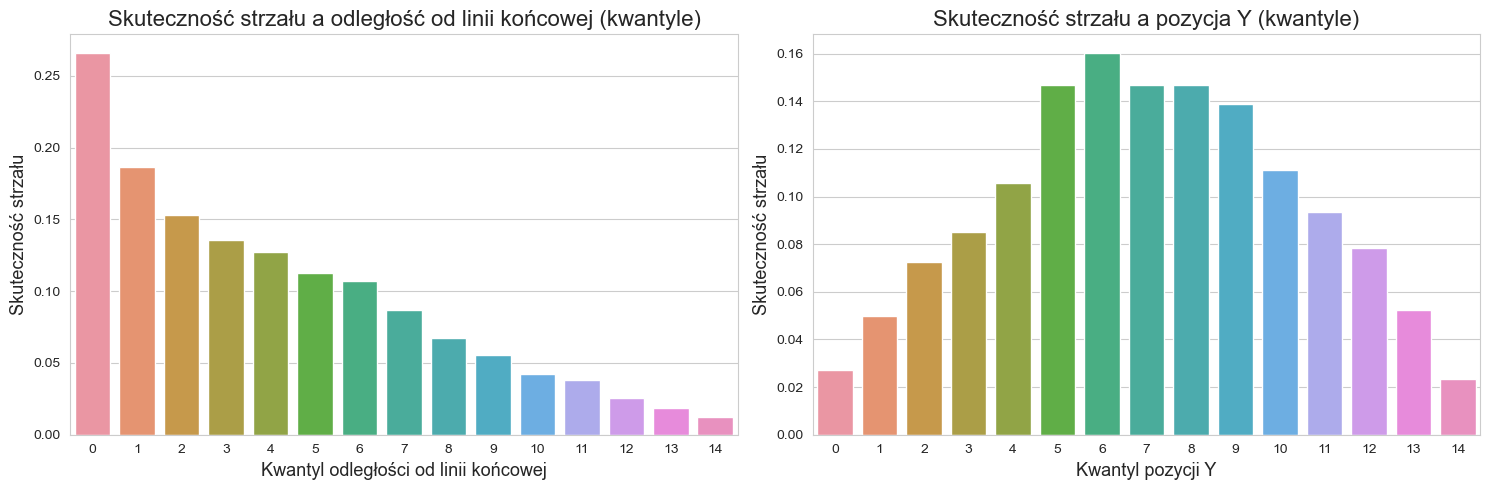

In [13]:
# Kwantyle dla współrzędnych
df_shots['x_quantile'] = pd.qcut(df_shots['distance_to_end_line'], q=15, labels=False)
df_shots['y_quantile'] = pd.qcut(df_shots['y'], q=15, labels=False)

# Skuteczność strzałów w zależności od kwantyla odległości od linii końcowej
df_eff_x = df_shots.groupby('x_quantile')['shot_outcome'].mean().reset_index()
df_eff_x['count'] = df_shots.groupby('x_quantile')['shot_outcome'].count().values

# Skuteczność strzałów w zależności od kwantyla y (szerokości boiska)
df_eff_y = df_shots.groupby('y_quantile')['shot_outcome'].mean().reset_index()
df_eff_y['count'] = df_shots.groupby('y_quantile')['shot_outcome'].count().values

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram skuteczności w zależności od kwantyla odległości od linii końcowej
sns.barplot(x=df_eff_x['x_quantile'].astype(str), y=df_eff_x['shot_outcome'], ax=axes[0])
axes[0].set_title('Skuteczność strzału a odległość od linii końcowej (kwantyle)', size=16)
axes[0].set_xlabel('Kwantyl odległości od linii końcowej', size=13)
axes[0].set_ylabel('Skuteczność strzału', size=13)

# Histogram skuteczności w zależności od kwantyla y
sns.barplot(x=df_eff_y['y_quantile'].astype(str), y=df_eff_y['shot_outcome'], ax=axes[1])
axes[1].set_title('Skuteczność strzału a pozycja Y (kwantyle)', size=16)
axes[1].set_xlabel('Kwantyl pozycji Y', size=13)
axes[1].set_ylabel('Skuteczność strzału', size=13)

plt.tight_layout()
plt.show()

Dzięki zastosowaniu kwantyli widzimy wyraźnie, że wraz ze wzrostem odległości od linii końcowej boiska skuteczność strzałów spada. Dla pierwszego kwantyla jest to ponad 25%, dla siódmego nieco ponad 10%, a dla ostatniego około 1-2%. Wyraźny wzorzec widać również dla wykresu skuteczności względem szerokości boiska (współrzędnej y). Strzały oddawane z pozycji centralnych charakteryzują się ponad 14% skuteczności, natomiast te z bocznych pozycji poniżej 5%.

Współrzędne x (a raczej 120-x) oraz y wydają się dobrymi zmiennymi różnicującymi. Można jednak zdefiniować dwie bardziej intuicyjne miary:
- **distance** - odległość od punktu, z którego oddano strzał (x,y) do środka bramki (120,40)
- **angle** - kąt jaki tworzy się między liniami łączącymi punkt strzału (x,y) ze słupkami bramki (120,36 oraz 120,44). Miara ta opisuje jak "duża" jest bramka z punktu widzenia strzelca. Będzie ona prawdopodobnie silnie negatywnie skorelowana ze zmienną **distance**, gdyż wraz ze wzrostem odległości będzie malał kąt.

In [14]:
df_shots['distance'] = np.sqrt((df_shots['distance_to_end_line'])**2+(abs(40-df_shots['y']))**2)

# Współrzędne słupków bramki
left_post = [120, 36]   # lewy słupek
right_post = [120, 44]  # prawy słupek

def calculate_shot_angle(x, y):
    # Wektory od punktu strzału do słupków
    vector_to_left = [left_post[0] - x, left_post[1] - y]
    vector_to_right = [right_post[0] - x, right_post[1] - y]
    
    # Długości wektorów
    mag_left = np.sqrt(vector_to_left[0]**2 + vector_to_left[1]**2)
    mag_right = np.sqrt(vector_to_right[0]**2 + vector_to_right[1]**2)
    
    # Iloczyn skalarny
    dot_product = vector_to_left[0]*vector_to_right[0] + vector_to_left[1]*vector_to_right[1]
    
    # Kąt w radianach
    angle_rad = np.arccos(dot_product / (mag_left * mag_right))
    
    # Kąt w stopniach
    angle_deg = angle_rad * 180 / np.pi
    
    return angle_deg

df_shots['angle'] = df_shots.apply(lambda row: calculate_shot_angle(row['x'], row['y']), axis=1)

df_shots[['distance', 'angle']].describe()

,distance,angle
count,45233.000000,45233.000000
mean,19.520543,24.874447
std,8.713346,15.362327
min,0.632456,0.000000
25%,12.376187,14.859554
50%,19.027612,19.278945
75%,25.927784,30.401229
max,88.833158,180.000000


Zmienna **distance** przyjmuje wartości od 0.63 (bardzo bliski strzał) do 88.8 (strzał z odległości większej niż wynosi szerokość boiska). Średnia odległość strzału to około 19.5 jednostek i niemal pokrywa się z medianą wynoszącą 19 jednostek. W przypadku kąta strzału (**angle**) wartości kształtują się od 0 (uderzenie z linii końcowej) do 180 (strzały z linii bramkowej). Średnia kształtuje się na poziomie 24.9 stopni natomiast mediana jest niższa i wynosi 19.3 stopnia.

Patrząc na statystyki opisowe zmiennej angle można postawić hipotezę, że jest ona silnie skośna prawostronnie. Świadczą o tym: 
- średnia wyższa od mediany, 
- asmyetria kwartyli, gdyż rożnice między kolejnymi wartościami to: 15°, 4.5°, 11° oraz 150° (!),
- stosunkowo wysokie odchylenie standardowe w porównaniu z rozkładem kwartyli

W dalszej części przyjrzę się dokładniej domniemanej asymetrii rozkładu.

### Zmienne kategorialne

#### Część ciała - better_foot, worse_foot, head

Surowe dane zawarte w zmiennej **body_part** mogą mieć ograniczoną moc predykcyjną, w zwiazku z tym, że różni zawodnicy mają inną nogę domiującą, a co za tym idzie część z nich będzie preferować uderzenia nogą prawą, a część lewą. Dane StatsBomb nie zawierają informacji o tym, która noga u zawodnika jest preferowana, dominująca. W związku z tym, postanowiłem dla każdego zawodnika sprawdzić, którą nogą oddawał więcej strzałów i uznać tę nogę za jego dominującą. W przypadku sytuacji, gdy zawodnik oddał tyle samo strzałów obiema nogami postanowiłem zakwalifikować go wówczas do grupy prawonożnych, gdyż takich zawodników jest zdecydowanie więcej niż lewonożnych. Nowe dane przypisałem do zmiennej **refined_body_part**.

In [15]:
# Krok 1: Przygotowanie danych - kodowanie nóg (1 dla prawej, 0 dla lewej)
foot_encoded = df_shots[df_shots['shot_body_part'].isin(['Right Foot', 'Left Foot'])].copy()
foot_encoded['is_right_foot'] = (foot_encoded['shot_body_part'] == 'Right Foot').astype(int)

# Krok 2: Obliczenie dominującej nogi dla każdego zawodnika
player_foot_dominance = foot_encoded.groupby('player_id')['is_right_foot'].mean().reset_index()

# Krok 3: Określenie dominującej nogi
player_foot_dominance['foot_type'] = 'dominant_right'
player_foot_dominance.loc[player_foot_dominance['is_right_foot'] <= 0.5, 'foot_type'] = 'dominant_left'

# Krok 4: Połączenie informacji o typie nogi z oryginalnym zbiorem danych
df_shots = df_shots.merge(player_foot_dominance[['player_id', 'foot_type']], on='player_id', how='left')

# Krok 5: Utworzenie nowej zmiennej refined_body_part
df_shots['refined_body_part'] = df_shots['shot_body_part']  

# Aktualizacja dla strzałów nogą
mask_right_foot = df_shots['shot_body_part'] == 'Right Foot'
mask_left_foot = df_shots['shot_body_part'] == 'Left Foot'

# Strzały dominującą lub niedominującą nogą
df_shots.loc[mask_right_foot & (df_shots['foot_type'] == 'dominant_right'), 'refined_body_part'] = 'better_foot'
df_shots.loc[mask_left_foot & (df_shots['foot_type'] == 'dominant_left'), 'refined_body_part'] = 'better_foot'
df_shots.loc[mask_right_foot & (df_shots['foot_type'] == 'dominant_left'), 'refined_body_part'] = 'worse_foot'
df_shots.loc[mask_left_foot & (df_shots['foot_type'] == 'dominant_right'), 'refined_body_part'] = 'worse_foot'
# Strzały głową
df_shots.loc[df_shots['shot_body_part'] == 'Head', 'refined_body_part'] = 'head'

# Filtrowanie DataFrame, zostawiając tylko wiersze z wybranymi wartościami (udział other tylko 0.24%)
df_shots = df_shots[df_shots['refined_body_part'].isin(['better_foot', 'worse_foot', 'head'])]

print(player_foot_dominance['foot_type'].value_counts(normalize=True)*100)
print(50*'-')
print(df_shots['refined_body_part'].value_counts(normalize=True)*100)

foot_type
dominant_right    67.092199
dominant_left     32.907801
Name: proportion, dtype: float64
--------------------------------------------------
refined_body_part
better_foot    66.224153
worse_foot     17.107334
head           16.668514
Name: proportion, dtype: float64


Po przeprowadzeniui powyższej klasyfikacji okazało się, że w zbiorze około 67% zawodników to zawodnicy prawonożni, a 33% stanowią zawodnicy lewnonożni. Po zastosowaniu feature engineering i utworzeniu **refined_body_part** otrzymałem nowy procentowy podział strzałów i zgodnie z nim 66% strzałów oddano lepszą nogą, 17% gorszą nogą i równiez około 17% to były strzały głową. Zgodnie z wcześniejszymi ustaleniami usunąłem obserwacje z etykietą "Others" gdyż stanowiły one jedynie 0.24% obserwacji.

#### Transformacja w zmienne binarne

Zgodnie z wcześniejszymi założeniami część zmiennych (**under_pressure**, **normal_shot**, **shot_first_time**, **open_play_shot**) przekształcam w zmienne binarne. Natomiast obserwacje z wartością *Corner* dla zmiennej **shot_type** usuwam ze zbioru (tylko 0.02% obserwacji).

In [16]:
df_shots['under_pressure'] = [1 if x==True else 0 for x in df_shots['under_pressure']]
df_shots['normal_shot'] = [1 if x=='Normal' else 0 for x in df_shots['shot_technique']]
df_shots['shot_first_time'] = [1 if x==True else 0 for x in df_shots['shot_first_time']]


df_shots = df_shots[df_shots['shot_type']!='Corner'] #tylko 0.02% obserwacji
df_shots['open_play_shot'] = [1 if x=='Open Play' else 0 for x in df_shots['shot_type']]

df_shots = df_shots.reset_index(drop=True)
df_shots.head()

,shot_outcome,under_pressure,shot_technique,shot_body_part,shot_type,shot_first_time,shot_open_goal,shot_one_on_one,shot_follows_dribble,shot_freeze_frame,...,y,distance_to_end_line,x_quantile,y_quantile,distance,angle,foot_type,refined_body_part,normal_shot,open_play_shot
0,1,1,Normal,Head,Open Play,0,NaN,NaN,NaN,"[{'location': [111.5, 8.3], 'player': {'id': 8...",...,35.7,8.0,2,5,9.082401,43.906819,dominant_right,head,1,1
1,0,0,Normal,Left Foot,Open Play,0,NaN,NaN,NaN,"[{'location': [99.1, 42.5], 'player': {'id': 5...",...,19.5,23.9,11,0,31.487458,11.089952,dominant_left,better_foot,1,1
2,0,1,Normal,Head,Open Play,0,NaN,NaN,NaN,"[{'location': [105.5, 29.6], 'player': {'id': ...",...,41.2,9.7,3,8,9.773945,44.296281,dominant_left,head,1,1
3,0,0,Half Volley,Left Foot,Open Play,1,NaN,NaN,NaN,"[{'location': [108.1, 30.7], 'player': {'id': ...",...,23.4,9.5,3,0,19.126160,12.257634,dominant_right,worse_foot,0,1
4,0,0,Normal,Right Foot,Open Play,1,NaN,NaN,NaN,"[{'location': [97.0, 55.6], 'player': {'id': 5...",...,56.0,15.3,7,14,22.137976,14.476435,dominant_right,better_foot,1,1


#### Transformacja shot_freeze_frame w defenders_in_path oraz goalkeeper_in_path

Użyteczne informacje można wyciągnąć ze zmiennej **shot_freeze_frame**. Zawiera ona współrzędne lokalizacji zawodników w momencie oddania strzału. Dzięki temu możliwe jest określenie ilu obrońców znajdowało się w świetle bramki oraz czy bramkarz znajdował się na drodze piłki. Jako obszar "w świetle bramki" uznałem trójkąt wyznaczony przez zawodnika strzelającego oraz słupki bramki. Jeżeli obrońca lub bramkarz znajdował się w tym trójkącie to zakwalifikowałem go jako obecnego na linii strzału (gdyż w praktyce zasłaniał on część bramki przed strzelcem). 

In [17]:
# transformacja shot_freeze_frame (string) do struktury Pythona
def parse_freeze_frame(freeze_frame_str):
    if isinstance(freeze_frame_str, str):
        try:
            return ast.literal_eval(freeze_frame_str)
        except (ValueError, SyntaxError):
            return None
    return freeze_frame_str

df_shots['shot_freeze_frame'] = df_shots['shot_freeze_frame'].apply(parse_freeze_frame)

In [18]:
def analyze_shot_path(freeze_frame, shooter_x, shooter_y, goal_left=[120, 36], goal_right=[120, 44]):

    shooter_loc = [shooter_x, shooter_y]
    
    # Funkcja pomocnicza do sprawdzenia czy punkt jest po lewej stronie linii
    def is_left(p0, p1, p2):
        return ((p1[0] - p0[0])*(p2[1] - p0[1]) - (p1[1] - p0[1])*(p2[0] - p0[0])) > 0
    
    # Liczniki
    defenders_count = 0
    goalkeeper_in_path = 0
    
    for player in freeze_frame:
        # Pomijanie graczy z drużyny strzelającej
        if player.get('teammate', True) == True or 'location' not in player:
            continue
        
        # Sprawdzenie lokalizacji względem trójkąta
        is_inside = (is_left(shooter_loc, goal_left, player['location']) != 
                     is_left(shooter_loc, goal_right, player['location']))
        
        if is_inside and player['location'][0] > shooter_loc[0]:
            if player.get('position', {}).get('name') == 'Goalkeeper':
                goalkeeper_in_path = 1
            else:
                defenders_count += 1
    
    return defenders_count, goalkeeper_in_path

# Wywołanie funkcji
result = df_shots.apply(
    lambda row: analyze_shot_path(
        row['shot_freeze_frame'], 
        row['x'], 
        row['y']
    ), 
    axis=1
)

df_shots['defenders_in_path'] = result.apply(lambda x: x[0] if x is not None else None)
df_shots['goalkeeper_in_path'] = result.apply(lambda x: x[1] if x is not None else None)

In [19]:
print("Częstotoliwości dla utworzonych zmiennych:")
print(50*'-')
print(df_shots['defenders_in_path'].value_counts(normalize=True)*100)
print(50*'-')
print(df_shots['goalkeeper_in_path'].value_counts(normalize=True)*100)


Częstotoliwości dla utworzonych zmiennych:
--------------------------------------------------
defenders_in_path
0    48.574532
1    34.255564
2    10.949277
3     4.123437
4     1.562916
5     0.434513
6     0.077592
7     0.015518
8     0.006651
Name: proportion, dtype: float64
--------------------------------------------------
goalkeeper_in_path
1    96.056132
0     3.943868
Name: proportion, dtype: float64


Zmienna **defenders_in_path** przyjmuje wartości od 0 do 8. Jednak zdecydowanie widać, że mniejsze wartości wyraźnie przeważają. W blisko 49% przypadków na drodze strzału nie było żadnego obrońcy, w 34% przypadków był jeden obrońca, w 11% akcji dwóch obrońców, a w 4% strzałów tych obrońców było trzech. Kolejne wartości są na tyle nieliczne, że postanowiłem je zgrupować razem z wartością 3.

Z kolei zmienna **goalkeeper_in_path** to zmienna binarna, która przyjmuje wartośc 1 gdy bramkarz był w promieniu strzału oraz 0 w przeciwnym wypadku. W 96% strzałów bramkarz znajdował się między strzlecem a bramką. 

In [20]:
df_shots['defenders_in_path'] = np.where(df_shots['defenders_in_path'] >= 3, 3, df_shots['defenders_in_path'])

Niskie liczby obrońców znajdujących się na ścieżce strzału mogą wydawać się mało intuicyjne. Wydaje się, że strzałów oddawanych w gąszcz obrońców widuje się całkiem sporo. Warto jednak zastanowić się nad poniższymi argumentami:

- Dynamika akcji ofensywnych - Profesjonalne drużyny celowo konstruują akcje tak, by izolować obrońców i tworzyć przestrzenie. Dobrze przeprowadzony atak prowadzi do sytuacji, w której na linii strzału znajduje się minimalna liczba przeciwników.
- Geometria boiska - Przestrzeń przed bramką jest ograniczona, a zawodnicy atakujący poruszają się w sposób, który naturalnie rozciąga formacje obronne. Każdy napastnik próbuje znaleźć tak zwaną "lukę" w obronie, co z definicji oznacza minimalizację liczby obrońców na linii strzału.

Jak się okazuje zawodnicy atakujący przykładają dużą wagę do tego by choć na chwile znaleźć przestrzeń do oddania jak najczystszego strzału. Oczywiście nie zawsze jest to możliwe, dużo zależy również od sposobu w jaki broni się drużyna przeciwna.

W celu lepszego zobrazowania omawianych sytuacji przygotowałem również wizualizacje ukazującą strzały zgromadzone w omawianym zbiorze danych. Wpisując losową liczbę od 0 do 45107 można zobaczyć jak wyglądało ustawienie zawodników w momencie strzału. Zauważalne jest to, że często obrońcy byli blisko trójkąta oznaczającego promień strzału. Świadczy to o tym, że rzeczywiście napastnicy starają się znaleźć ten moment kiedy liczba  przeciwników na linii uderzenia jest najmniejsza.

Shot number: 55


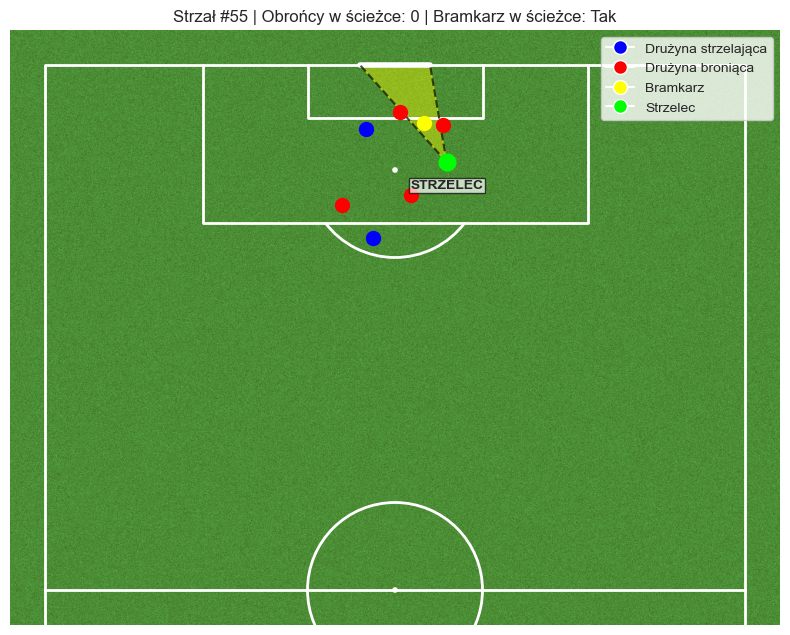

In [21]:
# Indeks strzału do analizy
n = int(input("Shot number: "))

# Pobranie danych o ustawieniu zawodników z DataFrame
freeze_frame = df_shots.loc[n, 'shot_freeze_frame']

# Pobieranie lokalizacji strzelca i bramki
striker_x = df_shots.loc[n, 'x']
striker_y = df_shots.loc[n, 'y']
goal_left = [120, 36]
goal_right = [120, 44]

# Zliczenie obrońców i bramkarza
defenders_count, goalkeeper_in_path = analyze_shot_path(
    freeze_frame, striker_x, striker_y, goal_left, goal_right
)

# Tworzenie wykresu
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='grass', line_color='white', 
                     goal_type='line', half=True)
fig, ax = pitch.draw(figsize=(8, 10))

for player in freeze_frame:
    x, y = player['location']
    
    # Bez zawodników z własnej połowy
    if x < 60:
        continue
    
    if player.get('teammate', False):
        jersey_color = 'blue'
    else:
        if player.get('position', {}).get('name') == 'Goalkeeper':
            jersey_color = 'yellow'
        else:
            jersey_color = 'red'
    
    ax.plot(y, x, 'o', markersize=10, color=jersey_color, zorder=2)
    
if striker_x >= 60:
    ax.plot(striker_y, striker_x, 'o', markersize=12, color='lime', zorder=4)
    ax.text(striker_y, striker_x - 3, f"STRZELEC", ha='center', fontsize=10, fontweight='bold', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', pad=1), zorder=5)
    
    # Linie strzału
    ax.plot([striker_y, goal_left[1]], [striker_x, goal_left[0]], 'k--', alpha=0.7, zorder=1)
    ax.plot([striker_y, goal_right[1]], [striker_x, goal_right[0]], 'k--', alpha=0.7, zorder=1)
    
    # Trójkąt strzału
    triangle = plt.Polygon(
        [[striker_y, striker_x], [goal_left[1], goal_left[0]], [goal_right[1], goal_right[0]]],
        alpha=0.4, color='yellow', zorder=0
    )
    ax.add_patch(triangle)

title = f"Strzał #{n} | Obrońcy w ścieżce: {defenders_count} | Bramkarz w ścieżce: {'Tak' if goalkeeper_in_path == 1 else 'Nie'}"
ax.set_title(title)

# Legenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Drużyna strzelająca'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Drużyna broniąca'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Bramkarz'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=10, label='Strzelec')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

## Eksploracja danych

### Analiza zmiennych binarnych względem zmiennej objaśnianej

W celu lepszego zrozumienia danych przyjrzałem się jak różni się skuteczność strzałów w zależności od wartości zmiennych binarnych (0/1). W tym celu stworzyłem wykresy kolumnowe dla zmiennych: **under_pressure**, **shot_first_time**, **normal_shot**, **open_play_shot**, **goalkeeper_in_path**. Lewa kolumna ilustruje procentową skuteczność dla obserwacji które dla danej zmiennej przyjmują wartość 0, natomiast prawa kolumna skutecznośc dla strzałów z etykietą 1 dla danej zmiennej.

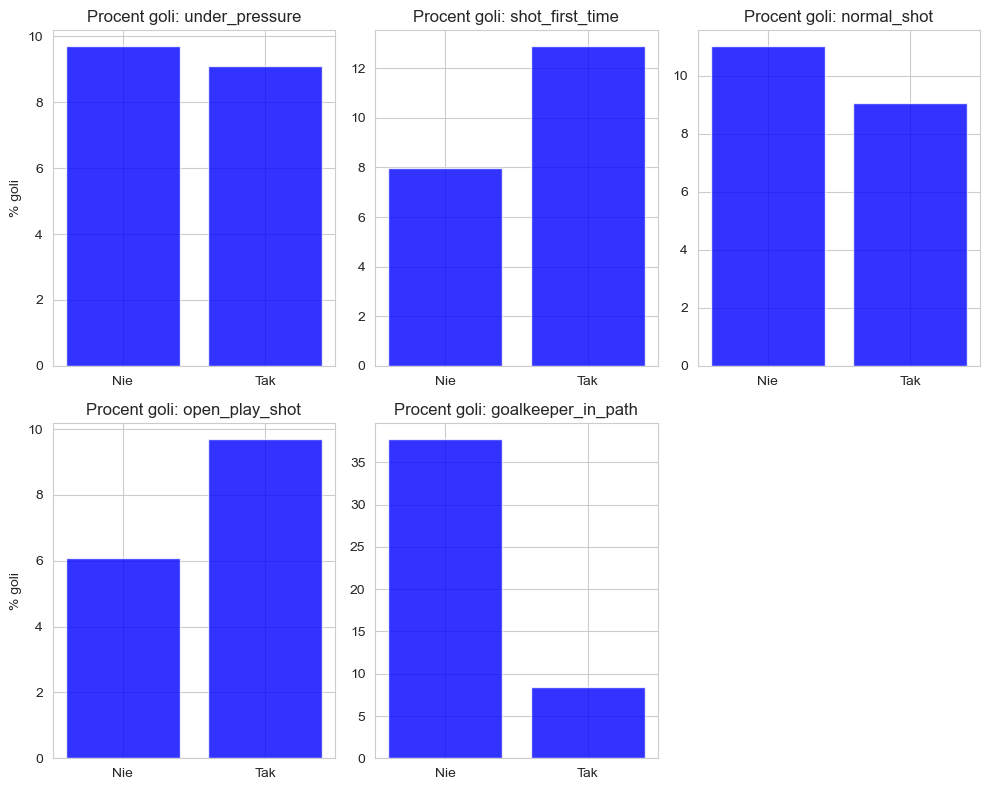

In [22]:
bin_features = ['under_pressure', 'shot_first_time', 'normal_shot', 'open_play_shot', 'goalkeeper_in_path']
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs_flat = axs.flatten()

for i, feature in enumerate(bin_features):
    # Procentu goli dla każdej wartości
    goal_rate_0 = df_shots[df_shots[feature] == 0]['shot_outcome'].mean() * 100
    goal_rate_1 = df_shots[df_shots[feature] == 1]['shot_outcome'].mean() * 100
    
    # Wykres słupkowy
    axs_flat[i].bar(['Nie', 'Tak'], [goal_rate_0, goal_rate_1], color='blue', alpha=0.8)
    axs_flat[i].set_title(f'Procent goli: {feature}')
    
    if i % 3 == 0: 
        axs_flat[i].set_ylabel('% goli')

axs_flat[-1].set_visible(False)

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

##### Under_pressure
- Strzały bez presji mają nieco wyższą skuteczność (ok. 9.8%) niż strzały pod presją (ok. 9.0%)
- Różnica jest stosunkowo niewielka, co sugeruje, że presja przeciwnika ma umiarkowany wpływ na skuteczność

##### Shot_first_time
- Strzały z pierwszej piłki mają znacznie wyższą skuteczność (ok. 12.5%) niż strzały poprzedzone kontrolą piłki (ok. 8%)
- To może wynikać z elementu zaskoczenia dla bramkarza lub faktu, że strzały z pierwszej piłki są zazwyczaj oddawane w lepszych sytuacjach

##### Normal_shot
- Normalne strzały mają wyższą skuteczność (ok. 10.7%) niż strzały wykonywane specjalnymi technikami (ok. 8.9%)
- Sugeruje to, że prostsze uderzenia są często bardziej efektywne niż te ekwilibrystyczne, bardziej zjawiskowe

##### Open_play_shot
- Strzały z akcji mają wyższą skuteczność (ok. 9.7%) niż strzały bezpośrednio z rzutów wolnych (ok. 6.0%)
- Ten wynik może być zaskakujący, bo stałe fragmenty gry są często uważane za dobre okazje bramkowe, ale z drugiej strony zarówno obrońcy jak i bramkarz są lepiej przygotowani do oddania strzału.

##### Goalkeeper_in_path
- Tutaj widać najwyraźniejszą różnicę: strzały bez bramkarza na linii mają skuteczność ok. 37.5%, podczas gdy strzały z bramkarzem na drodze tylko ok. 8.5%
- To potwierdza kluczową rolę bramkarza w obronie bramki - jego obecność w ścieżce strzału zmniejsza szansę na gola ponad czterokrotnie

Ta analiza pokazuje, że dla modelu xG kluczową zmienną może być obecność bramkarza na linii strzału. Inne zmienne, takie jak strzał z pierwszej piłki czy normalny strzał, również mają zauważalny wpływ na prawdopodobieństwo zdobycia bramki.

### Analiza skuteczności strzału w zależności od części ciała *(refined_body_part)*

Kolejną zmienną, której postanowiłem się przyjrzeć była **refined_body_part**. Zmienna ta zawiera trzy kategorie: *better_foot*, *worse_foot*, *head*. Intuicja podpowiada, że strzały wykonywane lepszą nogą powinny być zdecydowanie bardziej skuteczne niż te wykonywane słabszą. Dodatkowo noga dominująca powinna raczej gwarantować więcej goli niż strzały głową, które często są oddawane z trudnych sytuacji, w otoczeniu wielu obrońców.

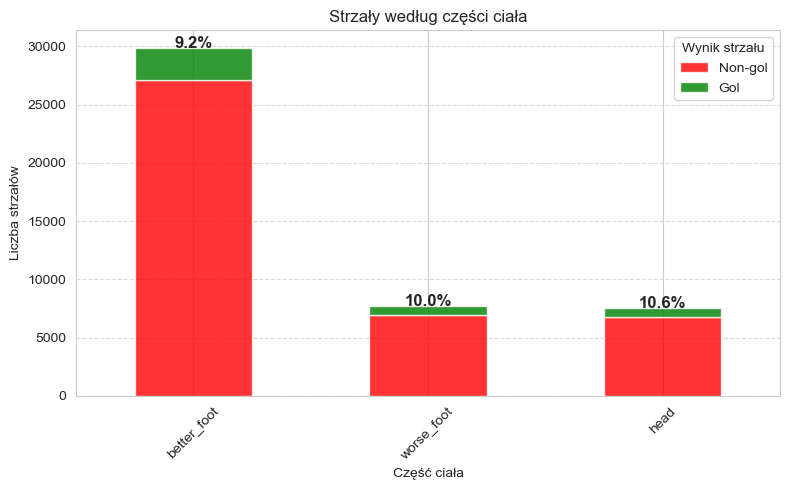

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

# Grupowanie danych według części ciała i wyniku strzału
body_part_counts = df_shots.groupby(['refined_body_part', 'shot_outcome']).size().unstack(fill_value=0)

if set(body_part_counts.columns) == {0, 1}:
    body_part_counts.columns = ['Non-gol', 'Gol']

# Sortowanie według łącznej liczby strzałów
body_part_total = body_part_counts.sum(axis=1).sort_values(ascending=False)
body_part_counts = body_part_counts.loc[body_part_total.index]

body_part_counts.plot(kind='bar', stacked=True, ax=ax, color=['red', 'green'], alpha=0.8)

# Ustawienia osi i tytułu
ax.set_title('Strzały według części ciała')
ax.set_xlabel('Część ciała')
ax.set_ylabel('Liczba strzałów')
ax.legend(title="Wynik strzału")

# Procentowe etykiety dla goli
for i, part in enumerate(body_part_counts.index):
    total = body_part_counts.loc[part].sum()
    if total > 0:  
        goal_rate = body_part_counts.loc[part, 'Gol'] / total * 100
        ax.text(i, total + 5, f"{goal_rate:.1f}%", ha='center', fontweight='bold', size=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Najwięcej strzałów jest oddawanych lepszą nogą, udział strzałów oddanych gorszą nogą jest porównywalny do strzałów oddanych głową i razem stanowią około połowy wolumenu wygenerowanego przez strzały lepszą nogą. Mimo to skuteczność dla wszystkich częsci ciała jest podobna i wynosi około 9-11%. Nie pokrywa się to z intuicyjnym podejściem. Z czego to może wynikać? Uderzając lepszą nogą piłkarze mogą być bardziej skłonni do ryzyka, tj. uderzenia z większego dystansu czy nieprzygotowanej pozycji. Dodatkowo piłkarze z silnie dominującą jedną nogą może być łatwiejsi do "przeczytania" przez obrońców i bramkarzowa (choć istnieją wyjątki jak legendarny Arjen Robben i jego zejście na lewą nogę). W celu lepszego zrozumienia tego nieintuicyjnego zjawiska stworzyłem wykres kolumnowy skumulowany pokazujący udział strzałów oddanych każdą częscią ciała (z tych trzech rozważanych) w zalezności od kwantyla dystansu.

<Figure size 1000x600 with 0 Axes>

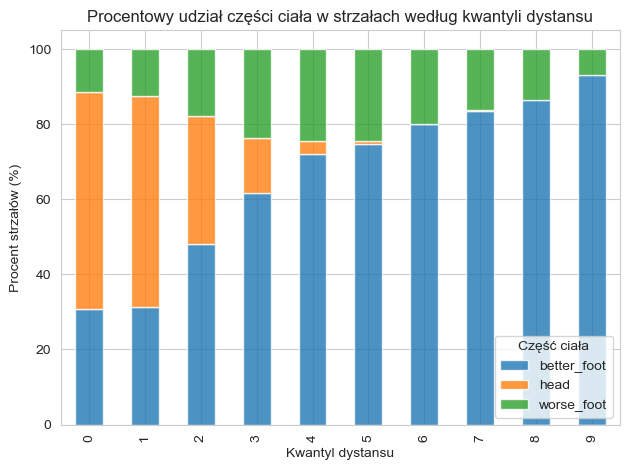

In [24]:
# Podział dystansu na kwantyle
df_shots['distance_quantile'] = pd.qcut(df_shots['distance'], q=10, labels=False)

# Analiza procentowa
quantile_distribution = df_shots.groupby(['distance_quantile', 'refined_body_part']).size().unstack(fill_value=0)
quantile_percentage = quantile_distribution.div(quantile_distribution.sum(axis=1), axis=0) * 100

# Wizualizacja
plt.figure(figsize=(10, 6))
quantile_percentage.plot(kind='bar', stacked=True, alpha=0.8)
plt.title('Procentowy udział części ciała w strzałach według kwantyli dystansu')
plt.xlabel('Kwantyl dystansu')
plt.ylabel('Procent strzałów (%)')
plt.legend(title='Część ciała', loc='lower right')
plt.tight_layout()

Powyższy wykres zdaje się potwierdzać tezę, że strzały lepszą nogą są zwykle oddawana z gorszej pozycji, z dalszej odległości. Po podzieleniu strzałów na 10 równolicznych kwantyli okazuje się, że w najniższych kwantylach (najlepsze pozycje) udział strzałów lepszą nogą to jedynie około 30%, natomiast w ostatnich czterech kwantylach ten udział przekracza 80%. Odwrotną sytuację widzimy ze strzałami głową - blisko 60% w pierwszym kwantylu i stopniowy spadek aż do szczątkowych wartości w 6. kwantylu. W przypadku strzałów słabszą nogą widzimy mały udział (ok.10-15%) w pierwszych kwantylach co jest spowodowane dużym udziałem strzałów głową. Natomiast wraz ze spadkiem udziału tej kategorii widzimy wzrost udziału strzałów słabszą nogą aż do kwantyli 4 i 5 kiedy to następuje stopniowe ustępowaniem strzałom wykonanym lepszą nogą. Powyższa obserwacja sygnalizuje, że choć całościwo skutecznośc nie jest zrożnicowana dla różnych częsci ciała to jednak wraz ze zmienną *distance* może pozytywnie wpłynąć na moc predykcyjną modelu.

### Analiza zmiennej porządkowej *(defenders_in_path)*

Kolejnym czynnikiem, który wydaje się niezwykle istotny dla skuteczności strzału wydaje się ilośc obrońców na drodze strzału (**defenders_in_path**). Jak zauważyłem we wcześniejszej częsci analizy zdecydowana większość strzałów jest oddawana w sytuacji, gdy na tej potencjalnej ścieżce strzału nie ma żadnego obrońcy (49% obserwacji) lub jest tylko jeden (34% obserwacji). Wydaje się zatem, że dla strzelca bardzo istotne jest minimalizowanie liczby przeciwników na odcinku między nim a bramką. Jeśli rzeczywiście jest to korzystne to powinny potwierdzać to dane.

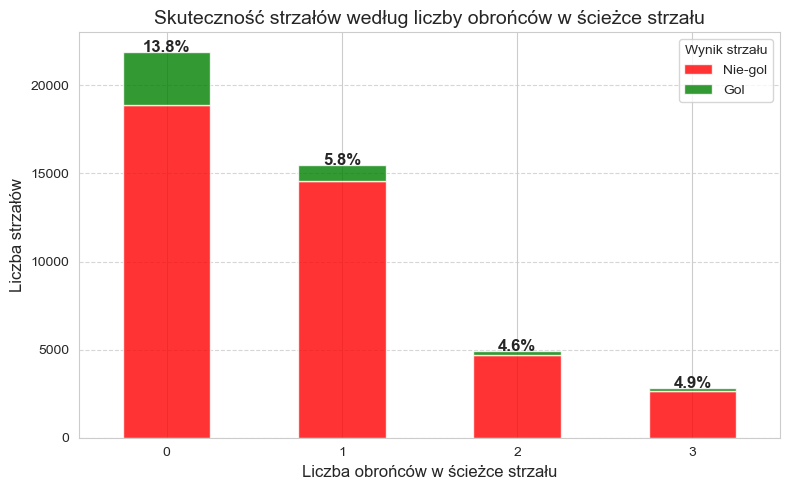

In [25]:
# Grupowanie danych według liczby obrońców w ścieżce i wyniku strzału
defenders_counts = df_shots.groupby(['defenders_in_path', 'shot_outcome']).size().unstack(fill_value=0)

if set(defenders_counts.columns) == {0, 1}:
    defenders_counts.columns = ['Nie-gol', 'Gol']

fig, ax = plt.subplots(figsize=(8, 5))

# Skumulowany wykres słupkowy
defenders_counts.plot(kind='bar', stacked=True, ax=ax, 
                     color=['red', 'green'], alpha=0.8)

# Etykiety i tytuł
ax.set_title('Skuteczność strzałów według liczby obrońców w ścieżce strzału', fontsize=14)
ax.set_xlabel('Liczba obrońców w ścieżce strzału', fontsize=12)
ax.set_ylabel('Liczba strzałów', fontsize=12)

# Procenty goli nad każdym słupkiem
for i, defenders in enumerate(defenders_counts.index):
    total = defenders_counts.loc[defenders].sum()
    if total > 0:  # bezpiecznik przed dzieleniem przez zero
        goal_rate = defenders_counts.loc[defenders, 'Gol'] / total * 100
        ax.text(i, total + 5, f"{goal_rate:.1f}%", ha='center', fontweight='bold', size=12)

ax.legend(title='Wynik strzału')

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Rzeczywiście w danych mamy potwierdzenie logiki, którą kierują się strzelcy. Strzały bez obrońców w ścieżce (*kategoria 0*) mają zdecydowanie najwyższą skuteczność - 13.8% tych strzałów kończy się bramką. Po pojawieniu się jednego obrońcy ta skutecznośc spada ponad dwukrotnie do 5.8%. Każdy kolejny obrońca na linii strzału nie wpływa już w tak wielkim stopniu na utrudnianie w zdobyciu bramki i dla sytuacji, gdy jest minimum dwóch obrońców wskaźnik skuteczności utrzymuje się nieco poniżej 5%.

Ta analiza jasno pokazuje, że liczba obrońców w ścieżce strzału jest bardzo ważnym czynnikiem przy modelowaniu xG. Szczególnie istotna jest różnica między strzałami bez obrońców a strzałami z choćby jednym obrońcą w ścieżce, co jest istotnym sygnałem dla drużyn broniących, że nawet jeden obrońca potrafi znacząco utrudnić zdobycie bramki. Natomiast wolumen strzałów bez obrońcy oraz z jednym obrońcą pokazuje jak ważne dla strzelców jest znalezienie optymalnej pozycji w odpowiednim czasie by oddać strzał i zmaksymalizować szanse na zdobycie bramki.

### Zmienne ciągłe: odległosć i kąt strzału

Obydwie zmienne ciągłe, tj. **distance** oraz **angle**, są oparte na tych samych surowych zmiennych, czyli **x** i **y** wyciągniętych ze zmiennej **location**. Powoduje to obawę, że mogą być one silnie zależne od siebie. W celu lepszego przyjrzenia się tym zmiennym stworzyłem heatmapę pokazującą jak zmienia się skuteczność strzału w zależności od kwantyla kąta i dystansu, a także wyznaczyłem macierz korelacji dla tych zmiennych.

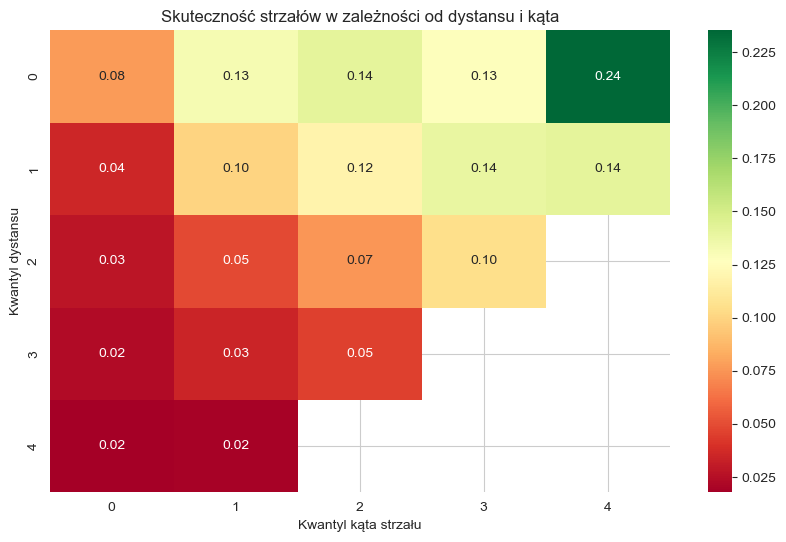

             angle  distance
angle     1.000000 -0.757387
distance -0.757387  1.000000
None


In [26]:
df_shots['distance_quantile'] = pd.qcut(df_shots['distance'], q=5, labels=False)
df_shots['angle_quantile'] = pd.qcut(df_shots['angle'], q=5, labels=False)

df_heatmap = df_shots.groupby(['distance_quantile', 'angle_quantile'])['shot_outcome'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Skuteczność strzałów w zależności od dystansu i kąta')
plt.xlabel('Kwantyl kąta strzału')
plt.ylabel('Kwantyl dystansu')
plt.show()


print(print(df_shots[['angle', 'distance']].corr()))

Słuszne były obawy o silną zależność obu zmiennych, gdyż jak wskazuje macierz wysepuje między nimi silna korelacja ujemna równa aż -0.75 (im większa odległość od bramki, tym mniejszy kąt strzału). 

Po analzie heatmapy możemy potwierdzić, że najwyższa skuteczność strzałów (0.24, czyli 24%) występuje przy małych odległościach i dużych kątach strzału, co jest zgodne z intuicją piłkarską. Gradient skuteczności jest widoczny zarówno wzdłuż osi odległości jak i kąta, ale wartości wzdłuż wierszy (dla stałej odległości) sugerują, że kąt strzału może być lepszym indywidualnym predyktorem skuteczności. Skuteczność drastycznie spada przy dużych odległościach, osiągając zaledwie 2% przy najdalszych strzałach. Przy dużych odległościach kąt strzału jest zawsze stosunkowo mały (co wynika z samej geometrii), co dodatkowo utrudnia zdobycie bramki.

Współliniowość zmiennych stanowi wyzwanie dla modelowania. Mimo silnej korelacji, zdecydowałem się zachować obie zmienne w dalszej analizie, planując zastosowanie technik regularyzacji w procesie modelowania, aby kontrolować potencjalne problemy związane ze współliniowością.

Ta analiza dostarcza cennych informacji o geometrycznych aspektach wpływających na skuteczność strzałów i będzie stanowić podstawę do budowy modelu expected goals (xG). Na potwierdzenie rozważań przygotowałem również wykres kolumnowy pokazujący jaka była skutecznośc strzału w zależności od kwantyla dystansu oraz analogiczny z podziałem na kwantyle kąta (tym razem podzieliłem dane na 15 kwantyli dla lepszego zobrazowania).

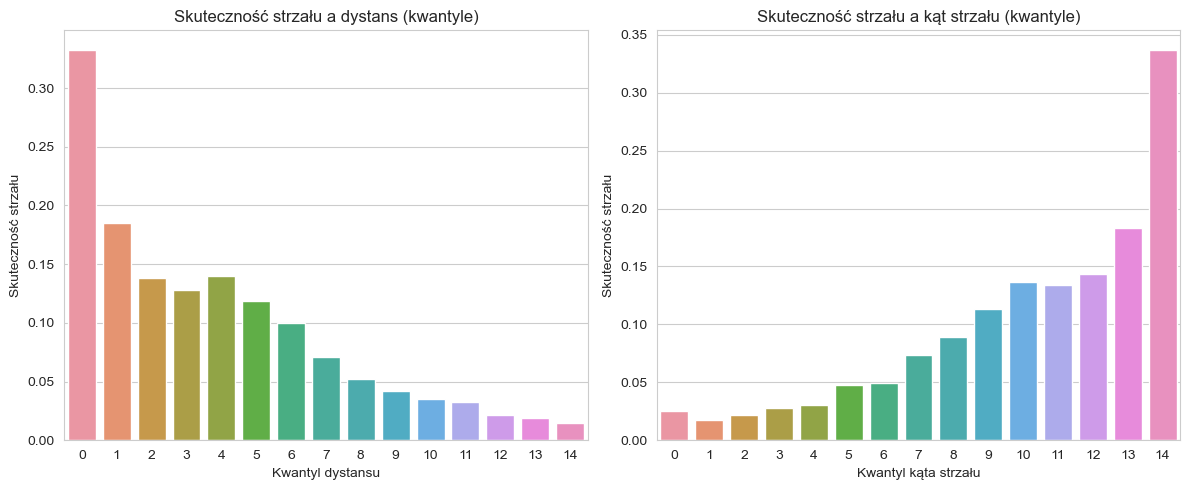

Skośność zmiennych:
Odległość: 0.578014
Kąt strzału: 2.182529


In [27]:
# Kwantyle dla distance i angle
df_shots['distance_quantile'] = pd.qcut(df_shots['distance'], q=15, labels=False)
df_shots['angle_quantile'] = pd.qcut(df_shots['angle'], q=15, labels=False)

# Skuteczność strzałów w zależności od zmiennej
df_eff_distance = df_shots.groupby('distance_quantile')['shot_outcome'].mean().reset_index()
df_eff_distance['count'] = df_shots.groupby('distance_quantile')['shot_outcome'].count().values

df_eff_angle = df_shots.groupby('angle_quantile')['shot_outcome'].mean().reset_index()
df_eff_angle['count'] = df_shots.groupby('angle_quantile')['shot_outcome'].count().values

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogramy skuteczności
sns.barplot(x=df_eff_distance['distance_quantile'].astype(str), y=df_eff_distance['shot_outcome'], ax=axes[0])
axes[0].set_title('Skuteczność strzału a dystans (kwantyle)')
axes[0].set_xlabel('Kwantyl dystansu')
axes[0].set_ylabel('Skuteczność strzału')

sns.barplot(x=df_eff_angle['angle_quantile'].astype(str), y=df_eff_angle['shot_outcome'], ax=axes[1])
axes[1].set_title('Skuteczność strzału a kąt strzału (kwantyle)')
axes[1].set_xlabel('Kwantyl kąta strzału')
axes[1].set_ylabel('Skuteczność strzału')

plt.tight_layout()
plt.show()

distance_skew = stats.skew(df_shots['distance'])
angle_skew = stats.skew(df_shots['angle'])

print("Skośność zmiennych:")
print(f"Odległość: {distance_skew:3f}")
print(f"Kąt strzału: {angle_skew:3f}")

W przypadku dystansu widzimy wyraźnie, że im większa odległość (wyższy kwantyl) tym mniejsza skuteczność strzału. Odwrotna sytuacja jest dla kąta strzału. Szansa rośnie z każdym kolejnym kwantylem - a zatem wraz ze wzrostem kąta strzału. Dodatkowo sprawdziłem skośność obu zmiennych ciągłych za treshold przyjmując wartośc 1. Zgodnie z przypuszczeniami silnie skośny jest rozkład kąta strzału (2.18) i na tej zmiennej bedzie konieczne zastosowanie logarytmizacji.

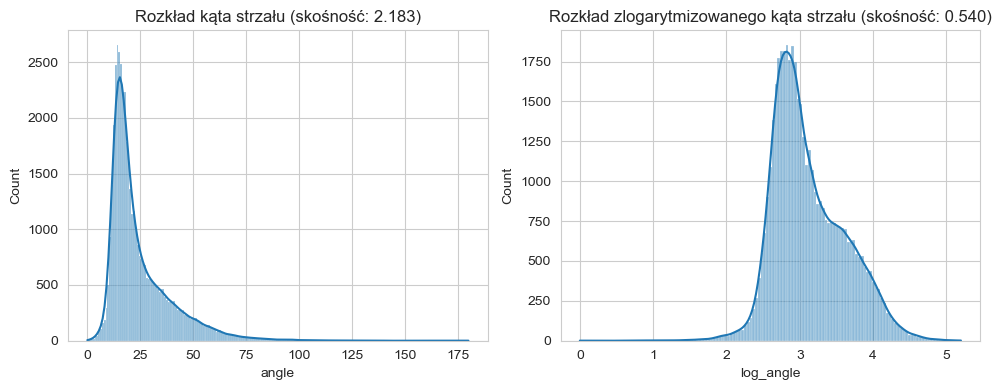

Skośność oryginalnych zmiennych:
Kąt strzału: 2.183

Skośność zlogarytmizowanych zmiennych:
Log(kąt strzału): 0.540


In [28]:
# Tworzenie zmiennej zlogarytmizowanej
df_shots['log_angle'] = np.log1p(df_shots['angle'])

angle_new_skew = stats.skew(df_shots['log_angle'])

# Histogramy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df_shots['angle'], kde=True, ax=axes[0])
axes[0].set_title(f'Rozkład kąta strzału (skośność: {angle_skew:.3f})')

sns.histplot(df_shots['log_angle'], kde=True, ax=axes[1])
axes[1].set_title(f'Rozkład zlogarytmizowanego kąta strzału (skośność: {angle_new_skew:.3f})')

plt.tight_layout()
plt.show()

# Wydruk wartości skośności
print("Skośność oryginalnych zmiennych:")
print(f"Kąt strzału: {angle_skew:.3f}")
print("\nSkośność zlogarytmizowanych zmiennych:")
print(f"Log(kąt strzału): {angle_new_skew:.3f}")

Analiza rozkładu zmiennej **angle** wykazała silną prawostronną asymetrię (skośność = 2.183). Większość obserwacji koncentrowała się w przedziale małych kątów (poniżej 25 stopni), co odpowiada trudniejszym sytuacjom strzeleckim, natomiast duże kąty (odpowiadające lepszym pozycjom) występują naturalnie znacznie rzadziej.
Zastosowanie transformacji logarytmicznej istotnie poprawiło rozkład zmiennej, redukując skośność do wartości 0.540. Uzyskany rozkład jest znacznie bliższy normalnemu, co zwiększy skuteczność modelowania statystycznego. Dzięki tej transformacji wpływ kąta strzału na prawdopodobieństwo zdobycia bramki zostanie lepiej uchwycony w całym zakresie wartości, co powinno przełożyć się na poprawę jakości modelu expected goals.

### Standaryzacja i dummy encoding

Po przeanalizowaniu zmiennych kolejnym krokiem była standaryzacja zmiennych ciągłych, gdyż jeden z przyszłych modeli - Regresja Logistyczna - wymaga takiego działania (pozostałe, tj. Lasy Losowe oraz XGBoost, nie wymagają). Dodatkowo wywołałem statystki opisowe dla tych zmiennych, aby ocenić czy transformacja przebiegła poprawnie.

In [29]:
continuous_vars = ['distance', 'log_angle'] 

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_shots[continuous_vars])
df_shots[['distance_scaled', 'log_angle_scaled']] = scaled_features

df_shots[['distance_scaled', 'log_angle_scaled']].describe()

,distance_scaled,log_angle_scaled
count,4.510800e+04,4.510800e+04
mean,-1.625610e-16,-1.241260e-15
std,1.000011e+00,1.000011e+00
min,-2.174349e+00,-6.344615e+00
25%,-8.203967e-01,-7.228099e-01
50%,-5.600621e-02,-2.251189e-01
75%,7.352403e-01,6.610891e-01
max,7.966568e+00,4.231395e+00


Standaryzacja przebiegła zgodnie z założeniami, tj. średnia zestandaryzowanych zmiennych jest bliska 0, a odchylenie standardowe wynosi 1. Małe odchylenia od idealnych wartości wynikają z ograniczonej precyzji obliczeń zmiennoprzecinkowych i są całkowicie normalne.

Następnym krokiem przygotowania zmiennych było stworzenie dummies na zmiennej kategorialnej (niebinarnej), czyli **refined_body_part**. W tym procesie powstały dwie nowe zmienne binarne: **better_foot**, **worse_foot**. W celu uniknięcia współliniowości usunąłem zmienną **head**. Wartości 0 dla obu zmiennych oznaczających strzał nogą są tożsame ze strzałem głową.

In [30]:
dummies = pd.get_dummies(df_shots['refined_body_part']).astype(int)
dummies_subset = dummies.drop('head', axis=1)
df_shots = pd.concat([df_shots, dummies_subset], axis=1)
df_shots = df_shots.drop('refined_body_part', axis=1) 

Ostatnią rzeczą jaką sprawdziłem przed rozpoczęciem budowy modelu była współliniowość zmiennych. W tym celu posłużyłem się VIF (Variance Inflation Factor). Przyjąłem następującą interpretację:
- VIF = 1: brak współliniowości
- 1 < VIF < 5: umiarkowana współliniowość
- 5 < VIF < 10: wysoka współliniowość (rozważenie usunięcia zmiennej)
- VIF > 10: bardzo wysoka współliniowość (usunięcie zmiennej)

In [31]:
X = df_shots[['distance_scaled', 'log_angle_scaled', 'under_pressure', 
             'shot_first_time', 'better_foot', 'worse_foot', 'normal_shot', 
             'open_play_shot', 'defenders_in_path', 'goalkeeper_in_path'
             ]]

# Obliczenie VIF dla każdej zmiennej
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

             Variable        VIF
9  goalkeeper_in_path  17.504479
7      open_play_shot  16.520393
4         better_foot   7.743056
6         normal_shot   4.576439
1    log_angle_scaled   3.598026
0     distance_scaled   3.575117
5          worse_foot   2.598610
3     shot_first_time   2.217216
8   defenders_in_path   1.929464
2      under_pressure   1.533719


Okazuje się, że bardzo wysoką współliniowość wykazują dwie zmienne: **goalkeeper_in_path** oraz **open_play_shot**. W związku z przyjętą interpretacją postanowiłem usunąc te dwie zmienne i zobaczyć jak wpłynie to na pozostałe zmienne (zwłaszcza na **better_foot**, które również ma dość wysoki wskaźnik VIF).

In [32]:
X1 = df_shots[['distance_scaled', 'log_angle_scaled', 'under_pressure', 
             'shot_first_time', 'better_foot', 'worse_foot', 'normal_shot', 'defenders_in_path'
             ]]

vif_data = pd.DataFrame()
vif_data["Variable"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

            Variable       VIF
4        better_foot  4.285506
0    distance_scaled  3.502131
1   log_angle_scaled  3.485778
6        normal_shot  3.051030
3    shot_first_time  2.147688
7  defenders_in_path  1.745667
5         worse_foot  1.727796
2     under_pressure  1.404169


Po usunięciu dwóch zmiennych z najwyższą współliniowością spadła współliniowość innych zmiennych, w tym **better_foot**, dla której wartość współczynnika VIF wynosi teraz 4.29 co jest akceptowalnym poziomem.

### Usunięcie zmiennych nieistotnych

Na koniec definitywnie usunąłem wspomniane wyżej dwie zmienne i w ten sposób zakończyłem proces przygotowywania zmiennych oraz ich selekcji.

In [33]:
df_shots = df_shots[[
        'shot_outcome', 'under_pressure',
       'shot_first_time', 'distance_scaled', 'log_angle_scaled', 
        'better_foot', 'worse_foot',
        'normal_shot', 'defenders_in_path',
        'shot_statsbomb_xg'
]]

print(df_shots.shape)
print(df_shots.head())

(45108, 10)
   shot_outcome  under_pressure  shot_first_time  distance_scaled  \
0             1               1                0        -1.202813   
1             0               0                0         1.373219   
2             0               1                0        -1.123302   
3             0               0                1        -0.048027   
4             0               0                1         0.298258   

   log_angle_scaled  better_foot  worse_foot  normal_shot  defenders_in_path  \
0          1.395579            0           0            1                  0   
1         -1.274038            1           0            1                  2   
2          1.413147            0           0            1                  0   
3         -1.086465            0           1            0                  1   
4         -0.771647            1           0            1                  0   

   shot_statsbomb_xg  
0           0.074454  
1           0.008508  
2           0.085069  


## BUDOWA MODELI

### PODZIAŁ NA ZBIORY TRENINGOWY I TESTOWY ORAZ RESAMPLING

W finalnym zbiorze danych pozostało 45 108 obserwacji z 1 zmienną objaśnianą (**shot_outcome**), 8 zmiennymi objaśniającymi (**under_pressure**, **shot_first_time**, **distance_scaled**, **log_angle_scaled**,  **better_foot**, **worse_foot**, **normal_shot**, **defenders_in_path**) oraz 1 zmienną pomocniczą do oceny pokrycia modelu z algorytmami StatsBomb (**shot_statsbomb_xg**).

W celu modelowania zbiór postanowiłem podzielić na dwie części: treningową i testową. Oba podzbiory pozostawały w stosunku 80:20. Dodatkowo ze względu na mały udział goli w ogólnej liczbie obserwacji dokonałem resamplingu. Moim celem było uzyskanie stosunku goli do nie-goli na poziomie 30:70. W związku z wystarczająco dużą liczbą obserwacji oraz silnym niezbalansowaniem uznałem, że lepszą opcją będzie undersampling (oversampling wiązałby się z ryzykiem przeuczenia, gdyż aż 2/3 goli w zbiorze treningowym byłoby dolosowane z już istniejących obserwacji).

In [34]:
X = df_shots.drop(['shot_outcome', 'shot_statsbomb_xg'], axis=1)
y = df_shots['shot_outcome']

# podział na treningowe/testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Undersampling na treningowych
rus = RandomUnderSampler(sampling_strategy=0.43, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Sprawdzenie proporcji
print(f"Proporcja goli po undersampLingu: {sum(y_train)/len(y_train):.2f}")

Proporcja goli po undersampLingu: 0.30


C:\Users\Bartek\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Bartek\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### ZDEFINIOWANIE EWALUACJI

In [35]:
def evaluate_model(model, X_test, y_test, threshold=0.5):

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Metryki
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)
    logloss = log_loss(y_test, y_pred_proba)
    precision_val = precision_score(y_test, y_pred)
    recall_val = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Przygotowanie wykresów
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate', size=14)
    axes[0].set_ylabel('True Positive Rate', size=14)
    axes[0].set_title('ROC Curve', size=18)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1], annot_kws={"size": 16})
    axes[1].set_xlabel('Predicted', size=14)
    axes[1].set_ylabel('Actual', size=14)
    axes[1].set_title(f'Confusion Matrix (threshold={threshold})', size=18)
    axes[1].set_xticks([0.5, 1.5])
    axes[1].set_yticks([0.5, 1.5])
    axes[1].set_xticklabels(['Non-goal', 'Goal'], size=11)
    axes[1].set_yticklabels(['Non-goal', 'Goal'], size=11)
    
    plt.tight_layout()
    plt.show()
    
    # Wyświetlenie metryk
    print(f"Model Performance Metrics (threshold={threshold}):")
    print(f"ROC AUC:     {roc_auc:.3f}")
    print(f"Brier Score: {brier:.3f}")
    print(f"Log Loss:    {logloss:.3f}")
    print(f"Precision:   {precision_val:.3f}")
    print(f"Recall:      {recall_val:.3f}")
    print(f"F1 Score:    {f1:.3f}")
    
    return {
        'ROC AUC': roc_auc,
        'Brier Score': brier,
        'Log Loss': logloss,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1
    }

Do oceny modeli wybrałem nastęujące mierniki: 

1. **ROC AUC (Area Under the Curve)** - mierzy zdolność modelu do rozróżniania między sytuacjami, które zakończą się golem a tymi, które nie. W przypadku xG, ważne jest nie tylko to, czy model przewiduje gola, ale czy dobrze ocenia relatywne prawdopodobieństwo różnych sytuacji strzeleckich. Dla swoich modeli oczekuję wyników powyżej 0.75 (idealny = 1.0, losowy = 0.5).

2. **Brier Score Loss** - mierzy jakość kalibracji modelu probabilistycznego, czyli jak dobrze przewidywane prawdopodobieństwa odpowiadają rzeczywistym wynikom. W kontekście xG oznacza to, czy sytuacje o przewidywanej wartości xG = 0.3 faktycznie kończą się golem w 30% przypadków. Oczekuję wyników poniżej 0.2 – im niższy wynik, tym lepsza kalibracja modelu.

3. **Log Loss** - ocena pewności modelu w przypisywaniu prawdopodobieństw. Model jest karany za bycie "pewnym" w błędnych predykcjach, np. gdy przypisuje xG = 0.9, a strzał nie kończy się golem. W przypadku xG log loss pozwala ocenić, jak dobrze model oddaje niepewność sytuacji strzeleckich. Oczekuję jak najniższych wartości, zazwyczaj poniżej 0.4.

4. **Precision** - mierzy, jaki procent przewidzianych goli rzeczywiście padło. Ważne w xG, gdy chcemy, aby model unikał fałszywych alarmów (np. zbyt wysokiego xG dla sytuacji, które nie kończą się golem). Dobre modele osiągają precision na poziomie 0.5+.

5. **Recall** - mierzy, jaki procent rzeczywistych goli model poprawnie przewidział. Istotne w xG, aby model wychwytywał wszystkie kluczowe sytuacje bramkowe, nawet te trudne do oceny. Oczekuję wartości powyżej 0.6, by model skutecznie identyfikował groźne strzały.

6. **F1 Score** - harmoniczna średnia Precision i Recall. Pozwala zbalansować model, który unika zarówno fałszywych alarmów (False Positive), jak i nie pomija kluczowych sytuacji bramkowych (False Negative). W przypadku xG oczekuję wyników w przedziale 0.6-0.7 jako solidnego balansu między precyzją a czułością.

Ewaluacje wzbogaciłem również o dwie wizualizacje:
1. **Krzywa ROC** pozwala ocenić, jak model radzi sobie z rozróżnianiem między sytuacjami bramkowymi a niebramkowymi.
2. **Macierz pomyłek (Confusion Matrix)** pokazuje, gdzie model popełnia błędy – czy zbyt często przewiduje gole tam, gdzie ich nie ma, czy odwrotnie.

### Model 1 - Regresja Logistyczna

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najlepsze parametry: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Najlepszy wynik: 0.7844


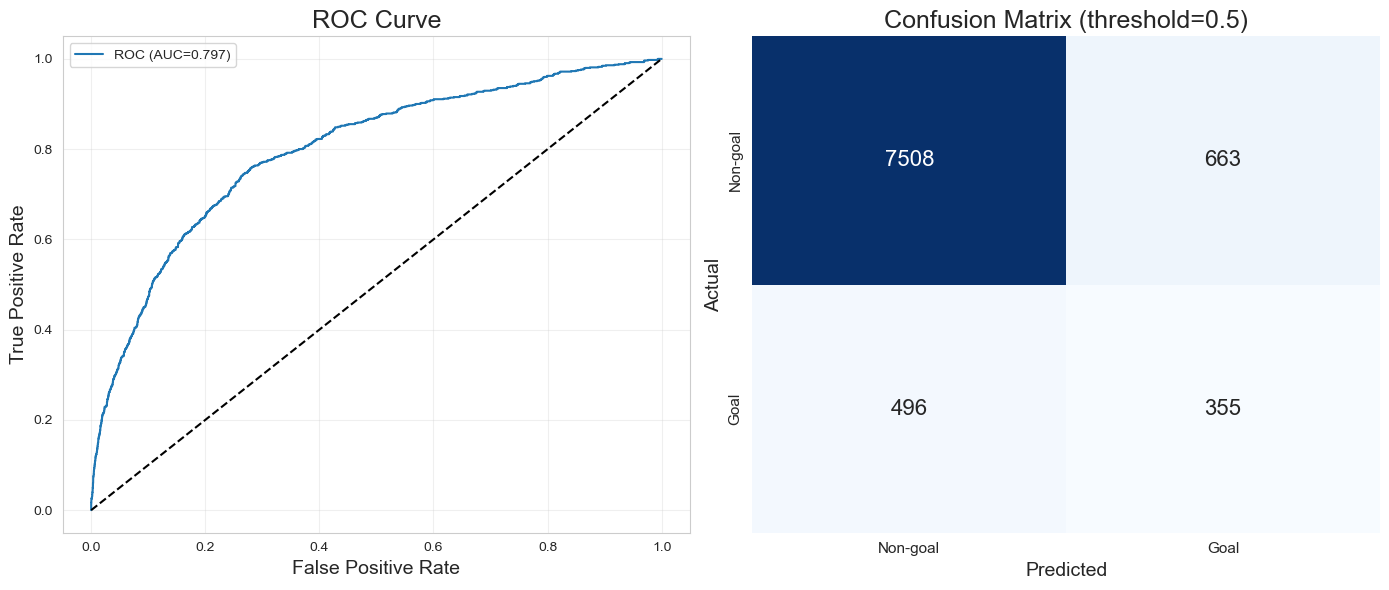

Model Performance Metrics (threshold=0.5):
ROC AUC:     0.797
Brier Score: 0.104
Log Loss:    0.353
Precision:   0.349
Recall:      0.417
F1 Score:    0.380


In [36]:
# Parametry do przeszukania
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Siła regularyzacji
    'penalty': ['l1', 'l2'],       # Typ regularyzacji
    'solver': ['liblinear'],       # Solver kompatybilny z l1 i l2
    'class_weight': [None, 'balanced']  # Opcja ważenia klas
}

# Inicjalizacja modelu
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# GridSearch z cross-walidacją
grid_search = GridSearchCV(
    log_reg, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Trenowanie na danych oversamplingowych
grid_search.fit(X_train, y_train)

# Najlepsze parametry
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_:.4f}")

# Najlepszy model
best_log_reg = grid_search.best_estimator_

# Ewaluacja na zbiorze testowym
metrics_log_reg = evaluate_model(best_log_reg, X_test, y_test)

#### Parametry modelu

Najlepszy model regresji logistycznej wykorzystuje **umiarkowaną regularyzację** (C=1, penalty='l2'), **bez dodatkowego ważenia klas**, co wskazuje że undersampling skutecznie zbalansował dane treningowe.

#### Metryki wydajności

Model osiąga solidne **ROC AUC 0.797** i niski **Brier Score 0.104**, co świadczy o dobrej zdolności różnicowania między sytuacjami bramkowymi oraz poprawnym kalibrowaniu prawdopodobieństw. **Precision 0.349** i **Recall 0.417** przekładają się na F1 Score **0.380**, co wskazuje na wciąż znaczące trudności w jednoczesnym utrzymaniu precyzji i czułości modelu.

#### Analiza błędów

Macierz pomyłek ujawnia, że model prawidłowo identyfikuje większość strzałów niecelnych (**7508 TN**), ale ma poważne trudności z wykrywaniem wszystkich bramek (**496 FN**). Model rozpoznaje tylko 42% faktycznych goli (**355 TP**) i generuje sporą liczbę fałszywych alarmów (**663 FP**).

#### Podsumowanie

Model xG prezentuje zadowalające wyniki w zakresie **kalibracji prawdopodobieństw** (Brier Score) i **dyskryminacji** (ROC AUC), ale znacząco gorzej radzi sobie z **klasyfikacją binarną**, co widać w niskich wartościach precision i recall. Stabilność między wydajnością na zbiorze treningowym i testowym potwierdza dobrą generalizację, jednak model nadal ma ograniczoną zdolność przewidywania, które strzały faktycznie zakończą się bramką. Stanowi on użyteczne narzędzie do porównywania **relatywnej jakości sytuacji strzeleckich**, ale wymaga ostrożnej interpretacji absolutnych wartości xG.

### Model 2 - Lasy Losowe


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Najlepsze parametry: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Najlepszy wynik: 0.7859


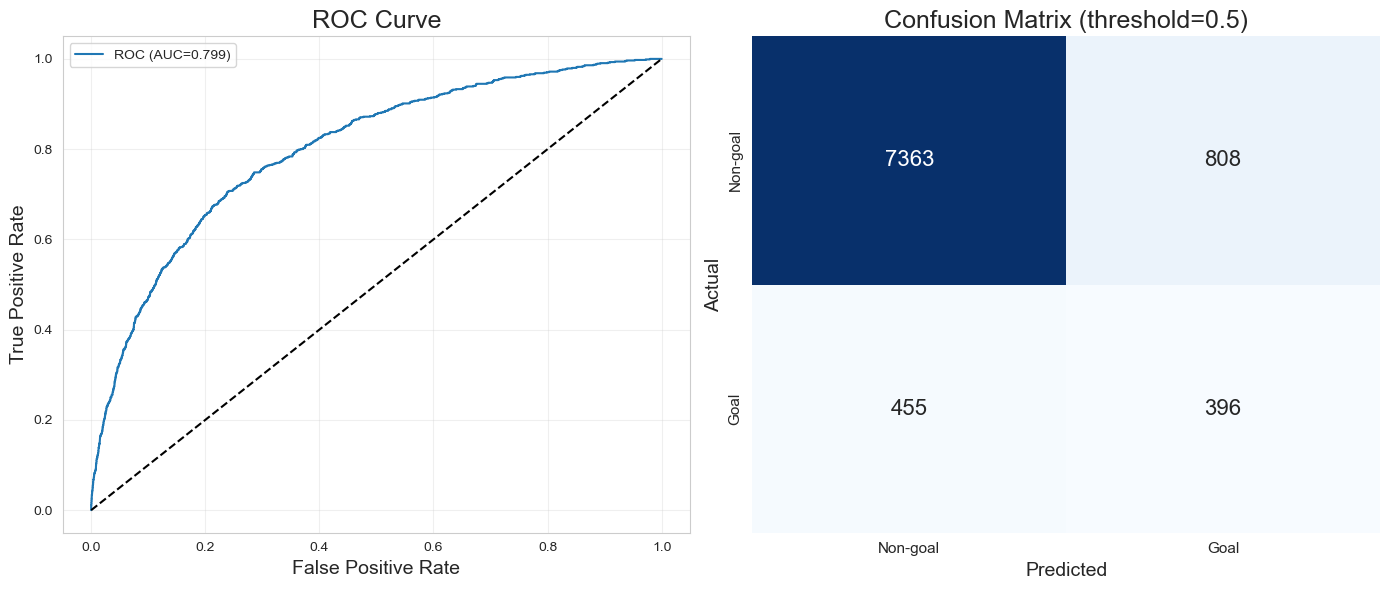

Model Performance Metrics (threshold=0.5):
ROC AUC:     0.799
Brier Score: 0.106
Log Loss:    0.353
Precision:   0.329
Recall:      0.465
F1 Score:    0.385


In [37]:
# Parametry do przeszukania
"""
param_grid = {
    'n_estimators': [100, 200],        # Liczba drzew
    'max_depth': [None, 10, 15],        # Maksymalna głębokość
    'min_samples_split': [2, 5],        # Min. liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2],          # Min. liczba próbek w liściu
    'max_features': ['sqrt', 'log2']        # Liczba cech do rozważenia przy podziale
}
"""
param_grid = {
    'n_estimators': [100],        # Liczba drzew
    'max_depth': [10],        # Maksymalna głębokość
    'min_samples_split': [2],        # Min. liczba próbek do podziału węzła
    'min_samples_leaf': [2],          # Min. liczba próbek w liściu
    'max_features': ['sqrt']        # Liczba cech do rozważenia przy podziale
}

# Inicjalizacja modelu
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearch z cross-walidacją
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Trenowanie na oversampleowanych danych
grid_search.fit(X_train, y_train)

# Najlepsze parametry
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_:.4f}")

# Najlepszy model
best_rf = grid_search.best_estimator_

# Ewaluacja na zbiorze testowym
metrics_rf = evaluate_model(best_rf, X_test, y_test)


#### Parametry modelu

Najlepszy model dla Lasów Losowych wykorzystuje drzewa o maksymalnej głębokości 10, z maksymalną liczbą cech równą pierwiastkowi kwadratowemu z liczby wszystkich cech ('sqrt'). Model wymaga minimum 2 próbek na liść oraz minimum 2 próbek do podziału węzła, przy liczbie estymatorów wynoszącej 100. Te parametry wskazują na **umiarkowaną złożoność modelu**, która zapobiega przeuczeniu.

#### Metryki wydajności

Model osiąga **ROC AUC 0.799**, co świadczy o dobrej zdolności różnicowania między sytuacjami prowadzącymi do bramki a pozostałymi. **Brier Score wynoszący 0.106** jest stosunkowo niski, wskazując na przyzwoitą kalibrację prawdopodobieństw. **Log Loss na poziomie 0.353** potwierdza umiarkowaną jakość probabilistyczną modelu. **Precision 0.329** oznacza, że około 1/3 strzałów przewidzianych jako gole faktycznie nimi była. **Recall 0.465** wskazuje, że model identyfikuje mniej niż połowę wszystkich faktycznych goli. F1 Score 0.385 odzwierciedla trudności w jednoczesnym utrzymaniu wysokiej precyzji i czułości.

#### Analiza błędów

Macierz pomyłek pokazuje, że model prawidłowo klasyfikuje większość strzałów niecelnych (**7363 TN**), ale generuje **808** fałszywych alarmów (FP). Model rozpoznaje około 47% faktycznych goli (**396 TP**), ale nie wykrywa pozostałych 53% (**455 FN**). Ta asymetria błędów jest typowa dla problemów z niezbalansowanymi klasami, jak w przypadku xG, gdzie gole stanowią mniejszość obserwacji.

#### Podsumowanie

Model Random Forest prezentuje **zadowalającą zdolność dyskryminacyjną** (ROC AUC) i **przyzwoitą kalibrację prawdopodobieństw** (Brier Score), ale napotyka trudności w precyzyjnym klasyfikowaniu strzałów jako gole/nie-gole. Wartości **precision i recall są niskie**, co sugeruje, że model ma **ograniczoną zdolność przewidywania**, które konkretne strzały zakończą się bramką. Główną zaletą jest **stabilność modelu**, potwierdzona zbliżonymi wynikami na zbiorze treningowym (0.7859) i testowym (0.799). Model może być użyteczny do porównywania jakości sytuacji strzeleckich i tworzenia rankingów, ale wartości absolutne xG powinny być interpretowane z ostrożnością.

### Model 3 - XGBoost

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Najlepsze parametry: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik: 0.7909


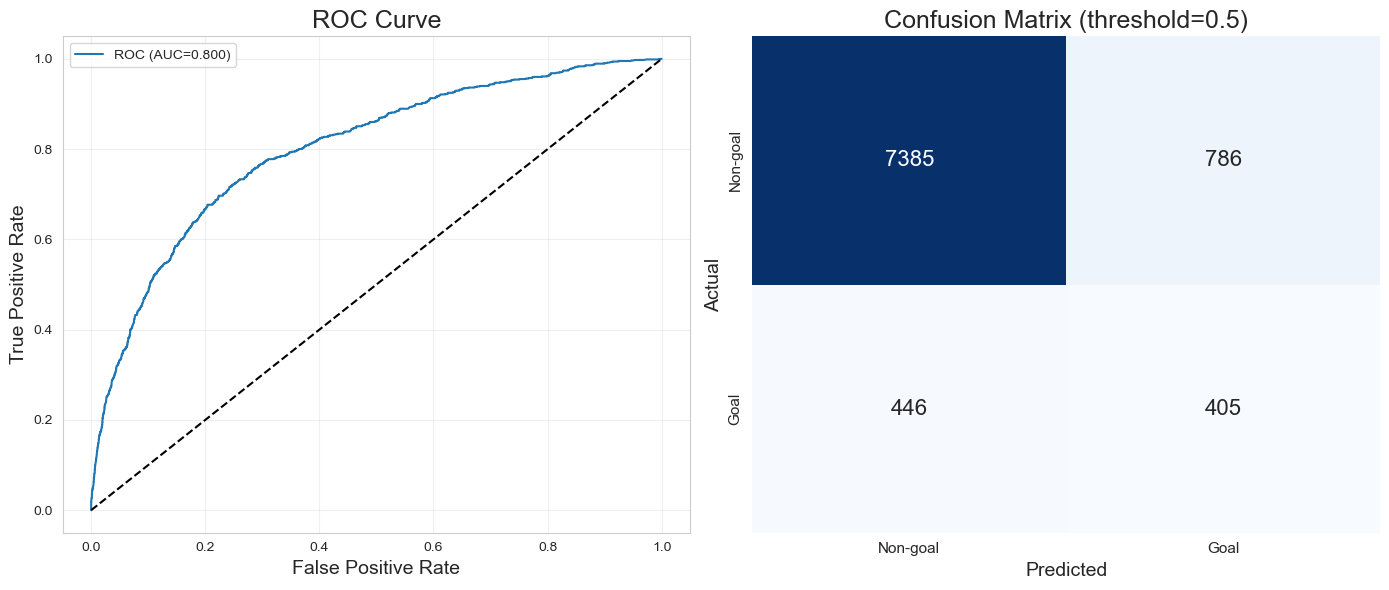

Model Performance Metrics (threshold=0.5):
ROC AUC:     0.800
Brier Score: 0.104
Log Loss:    0.350
Precision:   0.340
Recall:      0.476
F1 Score:    0.397


In [44]:

param_grid = {
    'n_estimators': [100],        # Liczba drzew boosting
    'max_depth': [3],            # Maksymalna głębokość drzewa
    'learning_rate': [0.1],      # Szybkość uczenia
    'subsample': [0.8],           # Odsetek próbek używanych dla każdego drzewa
    'colsample_bytree': [1.0]     # Odsetek cech używanych dla każdego drzewa
}
"""
param_grid = {
    'n_estimators': [100, 200, 300],        # Liczba drzew boosting
    'max_depth': [3, 6, 9],            # Maksymalna głębokość drzewa
    'learning_rate': [0.01, 0.1, 1],      # Szybkość uczenia
    'subsample': [0.8, 1.0],           # Odsetek próbek używanych dla każdego drzewa
    'colsample_bytree': [0.6, 0.8, 1.0]     # Odsetek cech używanych dla każdego drzewa
}
"""
# Inicjalizacja modelu
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,  
    objective='binary:logistic'
)

# GridSearch z cross-walidacją
grid_search = GridSearchCV(
    xgb, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Trenowanie na oversampleowanych danych
grid_search.fit(X_train, y_train)

# Najlepsze parametry i model
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik: {grid_search.best_score_:.4f}")
best_xgb = grid_search.best_estimator_

# Ewaluacja
metrics_xgb = evaluate_model(best_xgb, X_test, y_test)

#### Parametry modelu

Najlepszy model XGBoost wykorzystuje **pełną próbę** obserwacji na każde drzewo (colsample_bytree=1.0), **dość niską wartość współczynnika uczenia** (learning_rate=0.1), **płytkie drzewa** o maksymalnej głębokości 3, ze 100 estymatorami i **próbkowaniem 80% danych** (subsample=0.8) przy budowie każdego drzewa. Te hiperparametry wskazują na **zrównoważone podejście zapobiegające przeuczeniu**.

#### Metryki wydajności

Model osiąga **ROC AUC na poziomie 0.800**, co świadczy o dobrej zdolności różnicowania sytuacji bramkowych od niecelnych strzałów. **Brier Score wynoszący 0.104** wskazuje na dobrą kalibrację prawdopodobieństw, podobnie jak **Log Loss na poziomie 0.350**. **Precision 0.340** oznacza, że około 1/3 strzałów przewidzianych jako gole faktycznie kończy się bramką. **Recall 0.476** pokazuje, że model identyfikuje prawie połowę wszystkich faktycznych goli. **F1 Score 0.397** odzwierciedla kompromis między precyzją a czułością modelu.

#### Analiza błędów

Macierz pomyłek pokazuje, że model prawidłowo klasyfikuje większość strzałów niecelnych (**7385 TN**), choć generuje **786** fałszywych alarmów (FP). Model rozpoznaje około 48% faktycznych goli (**405 TP**), nie wykrywając pozostałych 52% (**446 FN**).

#### Podsumowanie

Model XGBoost prezentuje **solidne wyniki** z ROC AUC 0.800 i **dobrą kalibracją prawdopodobieństw** (Brier Score 0.104). Szczególnie godne uwagi jest osiągnięcie Recall na poziomie 0.476, co oznacza, że model identyfikuje **niemal połowę wszystkich faktycznych goli**. 

Płytkie drzewa (max_depth=3) sugerują, że model znajduje **proste, ale skuteczne reguły decyzyjne**, co może przekładać się na **lepszą interpretację wyników** - prawdopodobnie główne czynniki wpływające na wartości xG są związane z podstawowymi zmiennymi jak odległość od bramki, kąt strzału i obecność obrońców/bramkarza na linii strzału.

Model ten stanowi solidną podstawę do **praktycznych zastosowań w analizie piłkarskiej**, choć jak każdy model xG, ma ograniczenia w precyzyjnym przewidywaniu, które konkretne strzały zakończą się bramkami.

## Porównanie modeli

# Porównanie modeli Expected Goals (xG)

Analizując trzy modele wytrenowane do przewidywania Expected Goals (xG), należy rozpocząć od zrozumienia właściwego celu takiego modelu. Expected Goals nie służy do binarnej klasyfikacji strzałów jako "gol" lub "nie-gol", lecz do przypisania każdej sytuacji strzeleckiej wartości prawdopodobieństwa, które pozwala na porównywanie jakości różnych okazji bramkowych. Dobry model xG powinien precyzyjnie szeregować sytuacje od najlepszych do najgorszych oraz poprawnie kalibrować prawdopodobieństwa, aby odzwierciedlały rzeczywiste szanse zdobycia bramki.

## Porównanie kluczowych statystyk

| Metryka | Regresja Logistyczna | Random Forest | XGBoost |
|---------|---------------------|--------------|---------|
| ROC AUC | 0.797 | 0.799 | 0.800 |
| Brier Score | 0.104 | 0.106 | 0.104 |
| Log Loss | 0.353 | 0.353 | 0.350 |

Dla modelu xG szczególne znaczenie mają:
- ROC AUC - miara zdolności modelu do właściwego uszeregowania sytuacji strzeleckich
- Brier Score - miara jakości kalibracji prawdopodobieństw
- Log Loss - alternatywna miara jakości probabilistycznej, uwzględniająca pewność predykcji

## Wybór optymalnego modelu

Analizując wyniki pod kątem prawdziwego celu modelu xG, **XGBoost** jawi się jako najlepszy wybór z kilku powodów:

1. Osiąga najwyższy ROC AUC (0.800), co wskazuje na najlepszą zdolność do właściwego uporządkowania sytuacji strzeleckich od najlepszych do najgorszych - jest to kluczowa właściwość przy porównywaniu jakości okazji bramkowych.

2. Ma jeden z najniższych Brier Score'ów (0.104), co świadczy o dobrej kalibracji prawdopodobieństw - gdy model przewiduje xG=0.3, rzeczywiście około 30% takich sytuacji kończy się bramką.

3. Oferuje najniższy Log Loss (0.350), co sugeruje, że model jest najbardziej pewny swoich poprawnych predykcji i najmniej pewny błędnych.

4. Wykorzystuje zaledwie płytkie drzewa (max_depth=3), co wskazuje na uchwycenie istotnych wzorców bez nadmiernej komplikacji i potencjalnie lepszą generalizację na nowe dane.

Choć różnice w wynikach między modelami są stosunkowo niewielkie, XGBoost wydaje się najlepszym wyborem do praktycznej implementacji modelu xG. Warto podkreślić, że w praktyce analityki piłkarskiej, nawet niewielka przewaga w porządkowaniu sytuacji (ROC AUC) może mieć znaczący wpływ na jakość analiz długoterminowych, ocenę zawodników czy identyfikację niedocenianych lub przecenianych sytuacji strzeleckich.